In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import pandas as pd
import os
import PIL.Image as Image
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from plot_utils.MNIST_plot_utils import scale_to_unit_interval, save_ten_images, plot_ten_images, tile_raster_images
from plot_utils.ts_plot_utils import plot_ts, plot_ts_recon, save_ts, save_ts_recon
from plot_utils.heatmap import heatmap, annotate_heatmap

seed=30
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
def corrupt(X, eps, p_corr):
    X_all_corr = np.random.random(size=X.shape)
    #X_all_corr = X + eps * np.random.randn(X.shape[0], X.shape[1])
    #X_all_corr = np.clip(X_all_corr, 0, 1)
    mask = np.random.choice([0, 1], size=X.shape, p=[1-p_corr, p_corr]) != 0
    X_corr = X.copy()
    X_corr[mask] = X_all_corr[mask]
    return X_corr

def subsequences(ts, window):
    shape = (ts.size - window + 1, window)
    strides = ts.strides * 2
    return np.lib.stride_tricks.as_strided(ts, shape=shape, strides=strides)

In [3]:
def prox_l1(lam, x):
    return (x > lam) * (x - lam) + (x < -lam) * (x + lam)

def prox_l21(lam, x):
    e = np.linalg.norm(x, axis=0, keepdims=False)
    for i in range(len(e)):
        if e[i] > lam:
            x[:,i] = x[:,i] - lam*e[i]
        else:
            x[:,i] = np.zeros(len(x[:,i]))
    return x
    

def get_Dense_encoder(input_size, dense_units):
    encoder = tf.keras.Sequential()
    encoder.add(layers.Input(shape=(input_size)))
    for i in range(len(dense_units)):
        encoder.add(layers.Dense(units=dense_units[i], activation='relu'))
    return encoder

def get_Dense_decoder(input_size, dense_units):
    decoder = tf.keras.Sequential()
    decoder.add(layers.Input(shape=(dense_units[-1])))
    for i in reversed(range(len(dense_units)-1)):
        decoder.add(layers.Dense(units=dense_units[i], activation='relu'))
    decoder.add(layers.Dense(units=input_size, activation='sigmoid'))
    return decoder

def get_LSTM_encoder(timesteps, features, LSTM_units, LSTM_dropout):
    encoder = tf.keras.Sequential()
    if len(LSTM_units) > 0:
        encoder.add(layers.LSTM(units=LSTM_units[0], dropout=LSTM_dropout, return_sequences=True, input_shape=(timesteps, features)))
        for i in range(len(LSTM_units)-2):
            encoder.add(layers.LSTM(units=LSTM_units[i+1], dropout=LSTM_dropout, return_sequences=True))
        encoder.add(layers.LSTM(units=LSTM_units[-1], dropout=LSTM_dropout, return_sequences=False))
    else:
        encoder.add(layers.LSTM(units=LSTM_units[0], dropout=LSTM_dropout, return_sequences=False, input_shape=(timesteps, features)))            
    return encoder

def get_LSTM_decoder(timesteps, features, LSTM_units, LSTM_dropout):
    decoder = tf.keras.Sequential()
    decoder.add(layers.RepeatVector(timesteps))
    for i in reversed(range(len(LSTM_units))):
        decoder.add(layers.LSTM(units=LSTM_units[i], dropout=LSTM_dropout, return_sequences=True))
    decoder.add(layers.TimeDistributed(layer=layers.Dense(units=features, activation='sigmoid')))
    return decoder

In [4]:
### Deep Dense Autoencoder Model
class DAE_Dense(Model):
    def __init__(self, input_size, dense_units):
        super(DAE_Dense, self).__init__()
        self.encoder = get_Dense_encoder(input_size, dense_units)
        self.decoder = get_Dense_decoder(input_size, dense_units)
        
    def call(self, x, training=False):
        encoded = self.encoder(x, training=training)
        decoded = self.decoder(encoded, training=training)
        return decoded

    def encode(self, x, training=False):
        encoded = self.encoder(x, training=training)
        return encoded
    
    def decode(self, x, training=False):
        decoded = self.decoder(x, training=training)
        return decoded
    
    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Reconstruct input
            x_encoded = self.encode(x, training=True)
            x_recon = self.decode(x_encoded, training=True)
            # Calculate loss
            loss = self.compiled_loss(x, x_recon)
            
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(x, x_recon)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}


### Deep LSTM Autoencoder Model
class DAE_LSTM(Model):
    def __init__(self, timesteps, features, LSTM_units, LSTM_dropout):
        super(DAE_LSTM, self).__init__()
        self.encoder = get_LSTM_encoder(timesteps, features, LSTM_units, LSTM_dropout)
        self.decoder = get_LSTM_decoder(timesteps, features, LSTM_units, LSTM_dropout)
        
    def call(self, x, training=False):
        encoded = self.encoder(x, training=training)
        decoded = self.decoder(encoded, training=training)
        return decoded

    def encode(self, x, training=False):
        encoded = self.encoder(x, training=training)
        return encoded
    
    def decode(self, x, training=False):
        decoded = self.decoder(x, training=training)
        return decoded
    
    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Reconstruct input
            x_encoded = self.encode(x, training=True)
            x_recon = self.decode(x_encoded, training=True)
            # Calculate loss
            loss = self.compiled_loss(x, x_recon)
            
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(x, x_recon)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

In [5]:
### Robust Autoencoder Model
class RobustAutoencoder:
    def __init__(self, AE_type: str, prox_type: str, input_size=784, dense_units=[200, 10], lr=3e-4, timesteps=24, features=1, LSTM_units=[64, 32], LSTM_dropout=0.0):
        super(RobustAutoencoder, self).__init__()
        assert AE_type=='Dense' or AE_type=='LSTM', 'AE_type has to be either Dense or LSTM'
        self.AE_type = AE_type
        
        assert prox_type=='l1' or prox_type=='l21', 'prox_type has to be either l1 or l21'
        self.prox_type = prox_type
        
        if self.AE_type=='Dense':
            self.AE = DAE_Dense(input_size, dense_units)
            self.AE.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                loss='mse',
                metrics=['mse']
            )
            
        elif self.AE_type=='LSTM':
            self.AE = DAE_LSTM(timesteps, features, LSTM_units, LSTM_dropout)
            self.AE.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                loss='mse',
                metrics=['mse']
            )
        
        if self.prox_type=='l1':
            self.prox_fn = prox_l1
        elif self.prox_type=='l21':
            self.prox_fn = prox_l21
            
    def train_and_fit(self, X, train_iter: int, AE_train_iter: int, batch_size: int, eps: float, lam: float, verbose=0):
        if self.AE_type == 'Dense':
            self.default_shape = (X.shape[0], X.shape[1])
            self.utils_shape = (X.shape[0], X.shape[1])
        elif self.AE_type == 'LSTM':
            self.default_shape = (X.shape[0], X.shape[1], 1)
            self.utils_shape = (X.shape[0], X.shape[1])
        
        X = X.reshape(self.default_shape)
        self.L = np.zeros(self.default_shape)
        self.S = np.zeros(self.default_shape)
        self.LD = np.zeros(self.default_shape)
        self.LS = X
        
        for i in range(train_iter):
            if verbose!= 0:
                print(f'RAE training iteration: {i+1}')
            self.LD = X - self.S
            # Now fit the autoencoder for some iters
            self.AE.fit(x=self.LD, batch_size=batch_size, epochs=AE_train_iter, verbose=verbose)
            self.LD = self.AE(self.LD).numpy()
            self.S = X - self.LD
            
            self.S = self.S.reshape(self.utils_shape)
            self.S = self.prox_fn(lam=lam, x=self.S.T).T
            self.S = self.S.reshape(self.default_shape)
            
            c1 = tf.linalg.norm(X - self.LD - self.S) / tf.linalg.norm(X)
            c2 = tf.linalg.norm(self.LS - self.LD - self.S) / tf.linalg.norm(X)
            if c1 < eps or c2 < eps:
                print(f'Early Convergence at iter {i+1}')
                break
            self.LS = self.LD + self.S
        return self.LD, self.S
    
    def get_reconstruction(self, X):
        return self.AE(X)
    
    def transform(self, X):
        L = X - self.S
        return self.AE.encode(L)

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0], 784))
x_test = x_test.reshape((x_test.shape[0], 784))
    
x_train_corr = corrupt(x_train, eps=1., p_corr=0.25)

print(f'Train data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')

digit = 4
x_train_digit = x_train[y_train==digit]
np.random.shuffle(x_train_digit)
x_train_others = x_train[y_train!=digit]
np.random.shuffle(x_train_others)

anomaly_perc = 0.05

anomalies = np.random.choice(x_train_digit.shape[0], size=int(x_train_digit.shape[0]*anomaly_perc))
x_train_anomaly = x_train_digit.copy()
x_train_anomaly[anomalies] = x_train_others[:anomalies.shape[0]]
print(f'Total number of {digit}s in the anomaly data: {x_train_anomaly.shape[0]}, correct data: '
      f'{x_train_anomaly.shape[0]-anomalies.shape[0]}, anomalies: {anomalies.shape[0]}')



Train data shape: (60000, 784)
Test data shape: (10000, 784)
Total number of 4s in the anomaly data: 5842, correct data: 5550, anomalies: 292


## L21 Experiments

In [7]:
curr_dir = os.getcwd()
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''

    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

In [8]:
input_size = x_train_anomaly.shape[1]
dense_units = [200, 10]
lr = 3e-4
train_iter = 10
AE_train_iter = 40
batch_size = 128
eps = 1e-8


In [9]:
start = 5.4
stop = 5.6
step = 0.004
#start = 0.1
#stop = 10.1
#step = 0.1
lambda_l21_list = np.arange(start=start, stop=stop, step=step)
#lambda_l21_list = [7.7, 8.2]
lambda_l21_len = len(lambda_l21_list)

lambda_l21_accuracy = np.zeros(lambda_l21_len)
lambda_l21_recall = np.zeros(lambda_l21_len)
lambda_l21_precision = np.zeros(lambda_l21_len)
lambda_l21_f1 = np.zeros(lambda_l21_len)

for i, lam in enumerate(lambda_l21_list):
    print(f'Current iteration: {i+1} out of {lambda_l21_len}, lambda: {lam}')
    folder = os.path.join(curr_dir, 'l21_experiment', 'lam'+str(lam))
    mkdir_p(folder)
    
    RAEl21Dense = RobustAutoencoder(AE_type='Dense', prox_type='l21', input_size=input_size, dense_units=dense_units, lr=lr)
    LD_l21_MNIST, S_l21_MNIST = RAEl21Dense.train_and_fit(X=x_train_anomaly, train_iter=train_iter, AE_train_iter=AE_train_iter,
                                                          batch_size=batch_size, eps=eps, lam=lam, verbose=0)
    #print(S_l21_MNIST)
    inputsize = (28,28)
    Image.fromarray(tile_raster_images(X=S_l21_MNIST, img_shape=inputsize, tile_shape=(10, 10),tile_spacing=(1, 1))).save(os.path.join(folder, "l21S_MNIST.png"))
    Image.fromarray(tile_raster_images(X=RAEl21Dense.get_reconstruction(x_train_anomaly).numpy(), img_shape=inputsize, tile_shape=(10, 10),tile_spacing=(1, 1))).save(os.path.join(folder, "l21R_MNIST.png"))
    Image.fromarray(tile_raster_images(X=LD_l21_MNIST, img_shape=inputsize, tile_shape=(10, 10),tile_spacing=(1, 1))).save(os.path.join(folder, "l21L_MNIST.png"))
    
    #detected_anomalies = (np.sum((abs(S)>0.).astype(int), axis=1)>0.).astype(int)
    detected_anomalies_MNIST = (np.linalg.norm(S_l21_MNIST, axis=1) > 0.).astype(int)
    print(f'Detected_anomalies: {np.sum(detected_anomalies_MNIST)}')

    true_anomalies_MNIST = np.zeros(x_train_digit.shape[0]).astype(int)
    true_anomalies_MNIST[anomalies] = 1
    #np.sort(true_anomalies_MNIST)
    accuracy_MNIST = accuracy_score(y_pred=detected_anomalies_MNIST, y_true=true_anomalies_MNIST)
    precision_MNIST = precision_score(y_pred=detected_anomalies_MNIST, y_true=true_anomalies_MNIST)
    recall_MNIST = recall_score(y_pred=detected_anomalies_MNIST, y_true=true_anomalies_MNIST)
    f1_MNIST = f1_score(y_pred=detected_anomalies_MNIST, y_true=true_anomalies_MNIST)
    
    lambda_l21_accuracy[i] = accuracy_MNIST
    lambda_l21_precision[i] = precision_MNIST
    lambda_l21_recall[i] = recall_MNIST
    lambda_l21_f1[i] = f1_MNIST

    print(f'Accuracy: {accuracy_MNIST}, precision: {precision_MNIST}, recall: {recall_MNIST}, F1 score: {f1_MNIST}')
    
    with open(os.path.join(folder, 'result.txt'), 'w') as f:
            print(f'Accuracy: {accuracy_MNIST}, precision: {precision_MNIST}, recall: {recall_MNIST}, F1 score: {f1_MNIST}', file=f)
            
folder = os.path.join(curr_dir, 'l21_experiment')
with open(os.path.join(folder, 'result_smallest.txt'), 'w') as f:
    print(f'lambdas: {lambda_l21_list}', file=f)
    print(f'accuracies: {lambda_l21_accuracy}', file=f)
    print(f'precisions: {lambda_l21_precision}', file=f)
    print(f'recalls: {lambda_l21_recall}', file=f)
    print(f'f1 scores: {lambda_l21_f1}', file=f)


Current iteration: 1 out of 50, lambda: 5.4
Detected_anomalies: 284
Accuracy: 0.9597740499828826, precision: 0.5880281690140845, recall: 0.5859649122807018, F1 score: 0.5869947275922671
Current iteration: 2 out of 50, lambda: 5.404
Detected_anomalies: 274
Accuracy: 0.9659363231769942, precision: 0.656934306569343, recall: 0.631578947368421, F1 score: 0.6440071556350625
Current iteration: 3 out of 50, lambda: 5.4079999999999995
Detected_anomalies: 339
Accuracy: 0.9592605272167066, precision: 0.5693215339233039, recall: 0.6771929824561403, F1 score: 0.6185897435897436
Current iteration: 4 out of 50, lambda: 5.411999999999999
Detected_anomalies: 283
Accuracy: 0.9640534063676823, precision: 0.6325088339222615, recall: 0.6280701754385964, F1 score: 0.6302816901408451
Current iteration: 5 out of 50, lambda: 5.415999999999999
Detected_anomalies: 277
Accuracy: 0.9671345429647381, precision: 0.6678700361010831, recall: 0.6491228070175439, F1 score: 0.6583629893238435
Current iteration: 6 out of

Best F1 score: 0.6679245283018869 at lambda 5.467999999999993


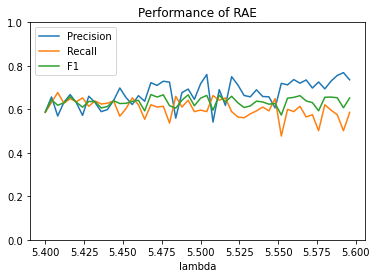

In [10]:
from cProfile import label


plt.figure()
#plt.plot(lambda_l21_list, lambda_l21_accuracy, label='Accuracy')
plt.plot(lambda_l21_list, lambda_l21_precision, label='Precision')
plt.plot(lambda_l21_list, lambda_l21_recall, label='Recall')
plt.plot(lambda_l21_list, lambda_l21_f1, label='F1')
plt.ylim(0,1)
plt.xlabel('lambda')
plt.title('Performance of RAE')
plt.legend()
plt.savefig('l21_experiment_from_'+str(start)+'_to_'+str(stop)+'.jpg')

print(f'Best F1 score: {np.max(lambda_l21_f1)} at lambda {lambda_l21_list[np.argmax(lambda_l21_f1)]}')


In [11]:
contaminations = np.arange(start=0.01, stop=0.5, step=0.01)
contaminations_len = len(contaminations)

if_accuracies = np.zeros(contaminations_len)
if_precisions = np.zeros(contaminations_len)
if_recalls = np.zeros(contaminations_len)
if_f1_scores = np.zeros(contaminations_len)

for i, cont in enumerate(contaminations):
    print(f'Current iteration: {i+1} of {contaminations_len}, contamination: {cont}')
    isol_forest = IsolationForest(random_state=seed, contamination=cont)
    isol_forest.fit(X=x_train_anomaly)
    if_anomaly_detected = isol_forest.predict(X=x_train_anomaly)
    if_anomaly_detected = ((-if_anomaly_detected) + 1) / 2
    if_anomaly_detected = if_anomaly_detected.astype(int)
    
    true_anomalies_MNIST = np.zeros(x_train_digit.shape[0]).astype(int)
    true_anomalies_MNIST[anomalies] = 1
    
    accuracy_if = accuracy_score(y_pred=if_anomaly_detected, y_true=true_anomalies_MNIST)
    precision_if = precision_score(y_pred=if_anomaly_detected, y_true=true_anomalies_MNIST)
    recall_if = recall_score(y_pred=if_anomaly_detected, y_true=true_anomalies_MNIST)
    f1_if = f1_score(y_pred=if_anomaly_detected, y_true=true_anomalies_MNIST)
    
    if_accuracies[i] = accuracy_if
    if_precisions[i] = precision_if
    if_recalls[i] = recall_if
    if_f1_scores[i] = f1_if
    
    print(f'Accuracy: {accuracy_if}, precision: {precision_if}, recall: {recall_if}, F1 score: {f1_if}')
    
    
folder = os.path.join(curr_dir, 'l21_experiment')
with open(os.path.join(folder, 'isolation_forest_result.txt'), 'w') as f:
    print(f'contaminations: {contaminations}', file=f)
    print(f'accuracies: {if_accuracies}', file=f)
    print(f'precisions: {if_precisions}', file=f)
    print(f'recalls: {if_recalls}', file=f)
    print(f'f1 scores: {if_f1_scores}', file=f)

Current iteration: 1 of 49, contamination: 0.01
Accuracy: 0.9558370421088668, precision: 0.7288135593220338, recall: 0.15087719298245614, F1 score: 0.25
Current iteration: 2 of 49, contamination: 0.02
Accuracy: 0.9548099965765149, precision: 0.5897435897435898, recall: 0.24210526315789474, F1 score: 0.34328358208955223
Current iteration: 3 of 49, contamination: 0.03
Accuracy: 0.9501882916809312, precision: 0.48295454545454547, recall: 0.2982456140350877, F1 score: 0.36876355748373096
Current iteration: 4 of 49, contamination: 0.04
Accuracy: 0.9443683669976035, precision: 0.41452991452991456, recall: 0.34035087719298246, F1 score: 0.3737957610789981
Current iteration: 5 of 49, contamination: 0.05
Accuracy: 0.9400890106128038, precision: 0.3890784982935154, recall: 0.4, F1 score: 0.39446366782006925
Current iteration: 6 of 49, contamination: 0.060000000000000005
Accuracy: 0.9359808284833961, precision: 0.3732193732193732, recall: 0.45964912280701753, F1 score: 0.41194968553459116
Current

Best F1 score: 0.41194968553459116 at contamination 0.060000000000000005


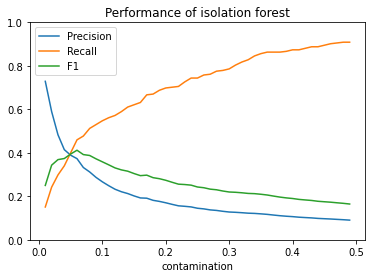

In [12]:
plt.figure()
#plt.plot(lambda_l21_list, lambda_l21_accuracy, label='Accuracy')
plt.plot(contaminations, if_precisions, label='Precision')
plt.plot(contaminations, if_recalls, label='Recall')
plt.plot(contaminations, if_f1_scores, label='F1')
plt.ylim(0,1)
plt.title('Performance of isolation forest')
plt.xlabel('contamination')
plt.legend()
plt.savefig('isolation_forest.jpg')

print(f'Best F1 score: {np.max(if_f1_scores)} at contamination {contaminations[np.argmax(if_f1_scores)]}')
